## Sensitivity Analysis for Sumo model
### Steps followed
1. Import the necessary libraries to the notebook
2. Initialize and load the Sumo model by providing the path and license file
3. Define and setup the input factors
4. Conduct the sensitivity analysis
5. Post processing and screening of influential factors

### Import libraries

In [1]:
from dynamita.sumo import *
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import stats   

In [2]:
from SALib.sample import morris
from SALib.analyze import morris as mr
import random

In [3]:
import seaborn as sns

In [4]:
%matplotlib inline

### Initialize and load the Sumo model

In [5]:
sumo = Sumo(sumoPath="C:/Users/zerualem/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [6]:
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    #snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
        sno2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno2_pos, i))
        sno3[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno3_pos, i))
    return 0

In [7]:
sumo.unload_model()
if not sumo.load_model('myGSBR.sumo'):
    print ('Model successfuly loaded!')

No model is loaded
Model successfuly loaded!


In [8]:
sumo.register_datacomm_callback(datacomm_callback)

In [9]:
snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
sno2_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO2')
sno3_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO3')
sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
print(snhx_pos)
print(sno2_pos)
print(sno3_pos)

86
87
88


### Test run the Sumo model

In [10]:
%%time 
stop_t=6*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)
t = []
snhx=[[] for i in range(6)]
sno2=[[] for i in range(6)]
sno3=[[] for i in range(6)]

sumo.run_model()

while not sumo.simulation_finished:
        time.sleep(0.01)

Wall time: 11.7 s


In [11]:
print(len(t))
stop_t/dataComm

121


120.0

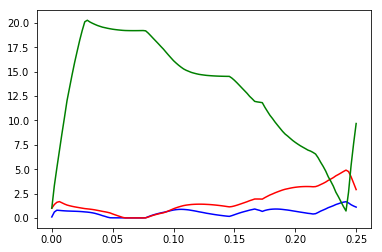

In [12]:
plt.plot(t,sno2[0],'b', t,sno3[0],'r', t,snhx[0], 'g')

In [13]:
titles=["Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
data_dict = dict(zip(titles,snhx))
dframe = pd.DataFrame(data_dict, index=t)

In [ ]:
dframe.head(10)

In [ ]:
dframe.plot()

### Start setting up the sensitivity analysis
#### Start with defining the input factors and their range
21 input factors have been selected to conduct the sensitivity analysis.

In [10]:
%%time
# Start Sensitivity analysis
# Define the model inputs
problem = {
    'num_vars': 23,
    'names': ['KO2_AOB_AS', 'KNHx_AOB_AS', 'muAOB', 'bAOB', 'YAOB', 'KO2_NOB_AS', 'KNO2_NOB_AS', 'muNOB', 'bNOB', 'YNOB', 'KNHx_AMX_AS', 'KNO2_AMX_AS', 'muAMX', 'bAMX', 'YAMX_NO2', 'YAMX_NO3', 'KO2_OHO_AS', 'KNO2_OHO_AS','KNO3_OHO_AS', 'muOHO', 'bOHO', 'YOHO_ox', 'YOHO_anox'],
    'bounds': [[0.1, 3], [0.1, 5], [0.2, 2], [0.01, 0.5], [0.03, 0.3], [0.1, 6], [0.1, 8], [0.1, 5], [0.1, 5], [0.03, 0.3], [0.1, 3], [0.1, 2], [0.01, 0.5], [0.001, 0.05], [0.03, 0.3], [0.03, 0.3], [0.05, 0.5], [0.1, 1], [0.1, 1], [0.1, 8], [0.01, 0.5], [0.1, 0.99],[0.1, 0.99]]
}


# Generate samples
param_values = morris.sample(problem, 30, num_levels=10, grid_jump=4) #optimal_trajectories= 60)

# Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

Wall time: 1.13 s


In [11]:
print(param_values.shape)
params_df=pd.DataFrame(param_values, columns=problem['names'])
params_df.head()

(720, 23)


,KO2_AOB_AS,KNHx_AOB_AS,muAOB,bAOB,YAOB,KO2_NOB_AS,KNO2_NOB_AS,muNOB,bNOB,YNOB,...,bAMX,YAMX_NO2,YAMX_NO3,KO2_OHO_AS,KNO2_OHO_AS,KNO3_OHO_AS,muOHO,bOHO,YOHO_ox,YOHO_anox
0,0.1,2.277778,0.8,0.391111,0.24,2.722222,2.733333,5.0,2.277778,0.24,...,0.05,0.18,0.24,0.1,0.4,0.4,5.366667,0.445556,0.990000,0.594444
1,0.1,2.277778,0.8,0.391111,0.24,2.722222,2.733333,5.0,2.277778,0.24,...,0.05,0.06,0.24,0.1,0.4,0.4,5.366667,0.445556,0.990000,0.594444
2,0.1,2.277778,1.6,0.391111,0.24,2.722222,2.733333,5.0,2.277778,0.24,...,0.05,0.06,0.24,0.1,0.4,0.4,5.366667,0.445556,0.990000,0.594444
3,0.1,2.277778,1.6,0.391111,0.24,2.722222,2.733333,5.0,2.277778,0.24,...,0.05,0.06,0.24,0.1,0.4,0.4,5.366667,0.445556,0.594444,0.594444
4,0.1,2.277778,1.6,0.391111,0.24,2.722222,2.733333,5.0,2.277778,0.24,...,0.05,0.06,0.24,0.1,0.4,0.4,5.366667,0.227778,0.594444,0.594444


### Plot the sample parameters 
The generated samples of the 21 input factors histogram is ploted below. This will help us to visualize how well the samples have been selected from the input space. We should expect approximately a uniform distribution otherwise we have to  re-generate the samples above until we are satisfied.

Wall time: 13.8 s


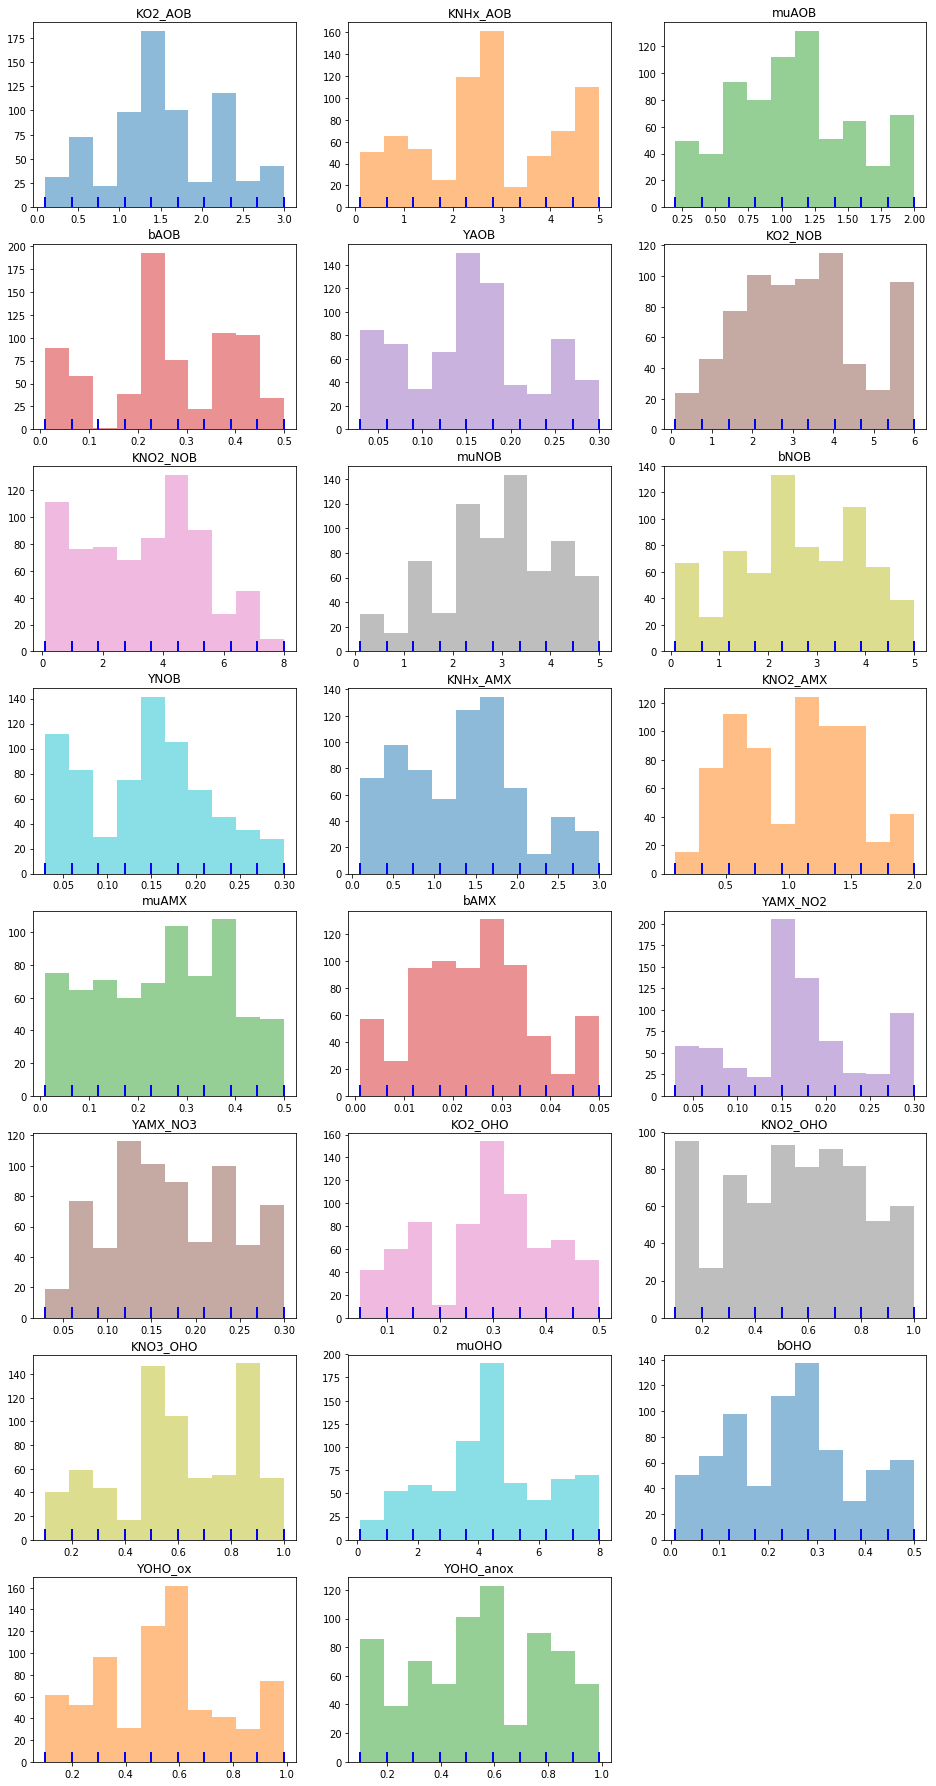

In [17]:
%%time
#selected_p=random.sample(param_values[:, 0].tolist(),3)
plt.figure(figsize=(16, 32))
cc=('C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1','C2')
for i in range(23):
    plt.subplot(8,3,i+1)
    plt.hist(param_values[:,i], histtype='stepfilled', alpha=0.5, color=cc[i] , bins=10)
    plt.title(problem['names'][i])
    sns.rugplot(param_values[:,i],lw=2, color='b')

In [ ]:
sns.pairplot(params_df[0:3])

In [ ]:
param_values[0:5,:]

In [ ]:
def converter(x): return ''.join(str(e) for e in 6*list(' '+ str(x)))
print(''.join(str(e) for e in 6*list(' '+ str(6.77))))
    
converter(4.5)
y=''.join(str(e) for e in 6*list(' '+ str(5.4)))
print(y)

### Start the sensitivity analysis

In [ ]:
set_cmd='set Sumo__Plant__GranularSBR__Sumo2__'
par_names=problem['names']
command=''
for j in range(len(par_names)):
        command +=set_cmd + par_names[j] + ' '+ str(param_values[i,j]) + '; \n'

print(command)

In [12]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()
sno2_sensitivity_data = OrderedDict()
sno3_sensitivity_data = OrderedDict()

stop_t=6*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)

t_out=int(stop_t/dataComm)
iteration=param_values.shape[0]
set_cmd='set Sumo__Plant__Sumo2__'
param_names=problem['names']
for i in range(iteration):
    #k=random.randint(0,719)
    command=''
    for j in range(len(param_names)):
        command +=set_cmd + param_names[j] + ' '+ str(param_values[i,j]) + '; \n'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration ', i)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for n in range(6)]
    sno2=[[] for n in range(6)]
    sno3=[[] for n in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx_sensitivity_data[i] = snhx[:t_out]
    sno2_sensitivity_data[i] = sno2[:t_out]
    sno3_sensitivity_data[i] = sno3[:t_out]

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
Iteration  57
Iteration  58
Iteration  59
Iteration  60
Iteration  61
Iteration  62
Iteration  63
Iteration  64
Iteration  65
Iteration  66
Iteration  67
Iteration  68
Iteration  69
Iteration  70
Iteration  71
It

Iteration  554
Iteration  555
Iteration  556
Iteration  557
Iteration  558
Iteration  559
Iteration  560
Iteration  561
Iteration  562
Iteration  563
Iteration  564
Iteration  565
Iteration  566
Iteration  567
Iteration  568
Iteration  569
Iteration  570
Iteration  571
Iteration  572
Iteration  573
Iteration  574
Iteration  575
Iteration  576
Iteration  577
Iteration  578
Iteration  579
Iteration  580
Iteration  581
Iteration  582
Iteration  583
Iteration  584
Iteration  585
Iteration  586
Iteration  587
Iteration  588
Iteration  589
Iteration  590
Iteration  591
Iteration  592
Iteration  593
Iteration  594
Iteration  595
Iteration  596
Iteration  597
Iteration  598
Iteration  599
Iteration  600
Iteration  601
Iteration  602
Iteration  603
Iteration  604
Iteration  605
Iteration  606
Iteration  607
Iteration  608
Iteration  609
Iteration  610
Iteration  611
Iteration  612
Iteration  613
Iteration  614
Iteration  615
Iteration  616
Iteration  617
Iteration  618
Iteration  619
Iteration 

In [ ]:
print(command)

In [13]:
#Put the dictionary into a numpy array
from tempfile import TemporaryFile

snhx_sens_list=list(snhx_sensitivity_data.values())
sno2_sens_list=list(sno2_sensitivity_data.values())
sno3_sens_list=list(sno3_sensitivity_data.values())
#print(min(len(x) for x in sens_list))
snhx_sens_array=np.array(snhx_sens_list)
sno2_sens_array=np.array(sno2_sens_list)
sno3_sens_array=np.array(sno3_sens_list)

print ("snhx array dim ", snhx_sens_array.ndim)
print ("sno2 array dim ", sno2_sens_array.ndim)
print ("sno3 array dim ", sno3_sens_array.ndim)
print ("snhx array shape ", snhx_sens_array.shape)
print ("sno2 array shape ", snhx_sens_array.shape)

snhx array dim  3
sno2 array dim  3
sno3 array dim  3
snhx array shape  (720, 6, 121)
sno2 array shape  (720, 6, 121)


In [26]:
print(snhx_sensitivity_data.keys())

odict_keys([227, 395, 388, 495, 116, 179, 229, 174, 172, 709])


In [14]:
with open('snhx_sens.txt','wb') as f:
    for a in snhx_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')

with open('sno2_sens.txt','wb') as f:
    for a in sno2_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')
        
with open('sno3_sens.txt','wb') as f:
    for a in sno3_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')

In [ ]:
snhx_layer0=snhx_sens_array[:,0,:]
print(snhx_layer0.shape)
snhx_layer0df= pd.DataFrame(snhx_layer0.T)
snhx_layer0df.head(20)

In [ ]:
### Plot the sensitivity modeling results

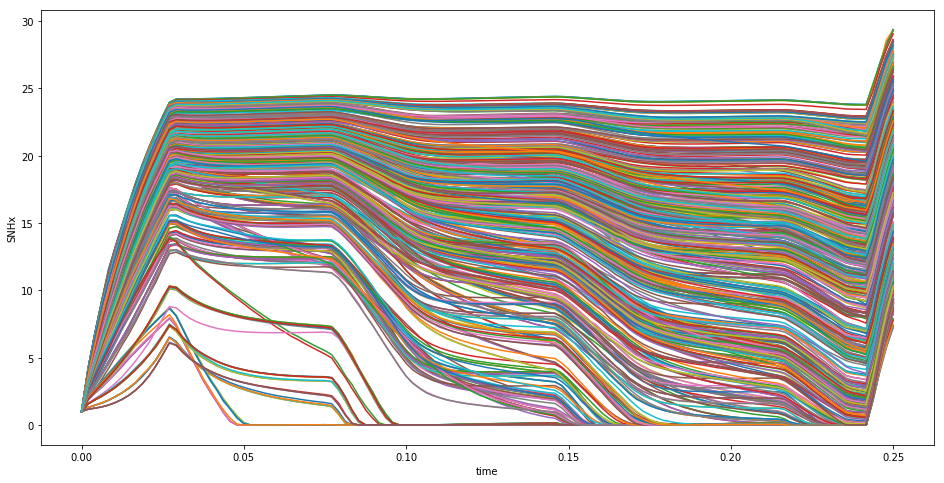

In [21]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('SNHx')
titles=("Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5")
markers=('_','x','o','^')
y_list=[]
fig.set_size_inches(16,8)
for k, v in snhx_sensitivity_data.items():
    
    ax.plot(t, v[0], label=str(k))
    y_list.append(v[0])

#plt.legend(loc='upper right', title='Legend')


In [ ]:
X=np.array(list(snhx_sensitivity_data.keys()))
Y=np.array(y_list)
corr=[]
#np.corrcoef(X,Y[:,-1])
for i in range(Y.shape[1]):
    corr.append(stats.pearsonr(X,Y[:,i])[0])
    


In [199]:
plt.plot(t, corr, 'ro')
plt.show()

In [77]:
Si=[]
Si_list_dict=[]
X=param_values
print("X size ", X.shape)
print(sens_array.shape[0]-1)
Si_ndarray=np.empty([4,2,121])
for i in range(sens_array.shape[2]-1):
    Y=sens_array[:,0,i]
    Si_out=mr.analyze(problem, X, Y, conf_level=0.95, print_to_console=False, num_levels=10, grid_jump=2)   
    Si_list_dict.append(Si_out)
    Si_list=list(Si_out.values())
    Si_array=np.array(Si_list)
    Si.append(Si_list)
    Si_ndarray[:,:,i]=Si_array[1:,:,]
    

X size  (300, 2)
299


In [83]:
Si_out.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

In [ ]:
plt.plot(t,Si_ndarray[1,0,:])
plt.plot(t,Si_ndarray[1,1,:])